In [1]:
import lammps
import random
from tqdm import trange
import pymc3 as pm
import arviz as az
import numpy as np
import pymatgen as pmg
import theano.tensor as tt
import glob

In [2]:
elements = ['Li', 'Ni', 'Oc', 'O']
# elements = pmg.Element('Li'), pmg.Element('Ni'), pmg.Element('Ge'), pmg.Element('O')
li, ni, oc, o = elements

pairs = [(li,o), (ni,o), (o,o)]

charges = {li: 1, ni: 3, oc: 0.960, o: -2.960}

bpp_def = {'Li_O_A'   : 456.783,
           'Li_O_rho' : 0.212,
           'Li_O_C'   : 0.0,
           'Ni_O_A'   : 1540.922,
           'Ni_O_rho' : 0.323,
           'Ni_O_C'   : 0.425,
           'O_O_A'    : 22764.7000,
           'O_O_rho'  : 0.1490,
           'O_O_C'    : 20.4}

bpp = {'Li_O_A'   : 456.783,
       'Li_O_rho' : 0.212,
       'Li_O_C'   : 0.0,
       'Ni_O_A'   : 1540.922,
       'Ni_O_rho' : 0.323,
       'Ni_O_C'   : 0.425,
       'O_O_A'    : 22764.7000,
       'O_O_rho'  : 0.1490,
       'O_O_C'    : 20.4}


In [3]:
def init():
    lmp = lammps.Lammps(units='metal', style = 'full', args=['-log', 'none', '-screen', 'none'])
    lmp.command('fix csinfo all property/atom i_CSID')
    lmp.command('read_data poscars/coords.lmp fix csinfo NULL CS-Info')

    lmp.command('group cores type 3')
    lmp.command('group shells type 4')

    lmp.command('pair_style buck/coul/long/cs 12.0') #ADD THE CS IF USING CORESHELLS NOT IF RIGID ION
    lmp.command('pair_coeff * * 0 1 0')
    
    lmp.command('bond_style harmonic')
    lmp.command('bond_coeff 1 65.0 0.0')
    
    lmp.command('kspace_style pppm 1e-6')
    
    for c in charges:
        lmp.command('set atom %d charge %f' % (elements.index(c)+1, charges[c]))
        
    #setup for minimization
    lmp.command('min_style cg')

    return lmp

In [4]:
def update_potentials(**kwargs):
    bpp.update(kwargs)
    
def set_potentials(instance):
    for pair in pairs:
        instance.command('pair_coeff {} {} {} {} {}'.format(dex(pair[0]),
                                                            dex(pair[1]),
                                                            bpp['{}_{}_A'.format(pair[0], pair[1])],
                                                            bpp['{}_{}_rho'.format(pair[0], pair[1])],
                                                            bpp['{}_{}_C'.format(pair[0], pair[1])]))

def dex(elin): return elements.index(elin) + 1

In [5]:
def simfunc(**kwargs):
    if min(kwargs.values()) > 0:
        update_potentials(**kwargs)
        out = np.zeros([instances.system.total,3])
        
        set_potentials(instances)

        instances.command('fix 1 cores setforce 0.0 0.0 0.0')
        instances.command('minimize 1e-5 1e-5 5000 10000')
        instances.command('unfix 1')
        instances.run(0)
        
        out = instances.system.forces
            
    else: out = np.ones([instances.system.total,3])*999999999 # ThisAlgorithmBecomingSkynetCost
        
    return out

In [6]:
instances = init()

In [7]:
expected = np.zeros([instances.system.total,3])

In [8]:
with pm.Model() as model:
#  pm.TruncatedNormal -- truncated so never tries a negative    pm.Uniform
    Li_O_A      = pm.Normal("Li_O_A",    mu = bpp_def['Li_O_A'],    sd =  100)
    Li_O_rho    = pm.Normal("Li_O_rho",  mu = bpp_def['Li_O_rho'],  sd =  0.05)
#     Li_O_C      = pm.Normal("Li_O_C",    mu = bpp_def['Li_O_C'],    sd =  0.01)
    Ni_O_A      = pm.Normal("Ni_O_A",    mu = bpp_def['Ni_O_A'],    sd =  100)
    Ni_O_rho    = pm.Normal("Ni_O_rho",  mu = bpp_def['Ni_O_rho'],  sd =  0.05)
    Ni_O_C      = pm.Normal("Ni_O_C",    mu = bpp_def['Ni_O_C'],    sd =  0.05)
    O_O_A       = pm.Normal("O_O_A",     mu = bpp_def['O_O_A'],     sd =  100)
    O_O_rho     = pm.Normal("O_O_rho",   mu = bpp_def['O_O_rho'],   sd =  0.05)
    O_O_C       = pm.Normal("O_O_C",     mu = bpp_def['O_O_C'],     sd =  5)
    
    simulator = pm.Simulator('simulator', simfunc, observed=expected)
    
    trace = pm.sample(step=pm.SMC(ABC=True, epsilon=0.1), draws=1000)


Sample initial stage: ...
/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pymc3/step_methods/smc.py:176: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Stage: 0 Beta: 0.469 Steps: 25
Stage: 1 Beta: 1.000 Steps: 24


/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129b006a0>,
      dtype=object)

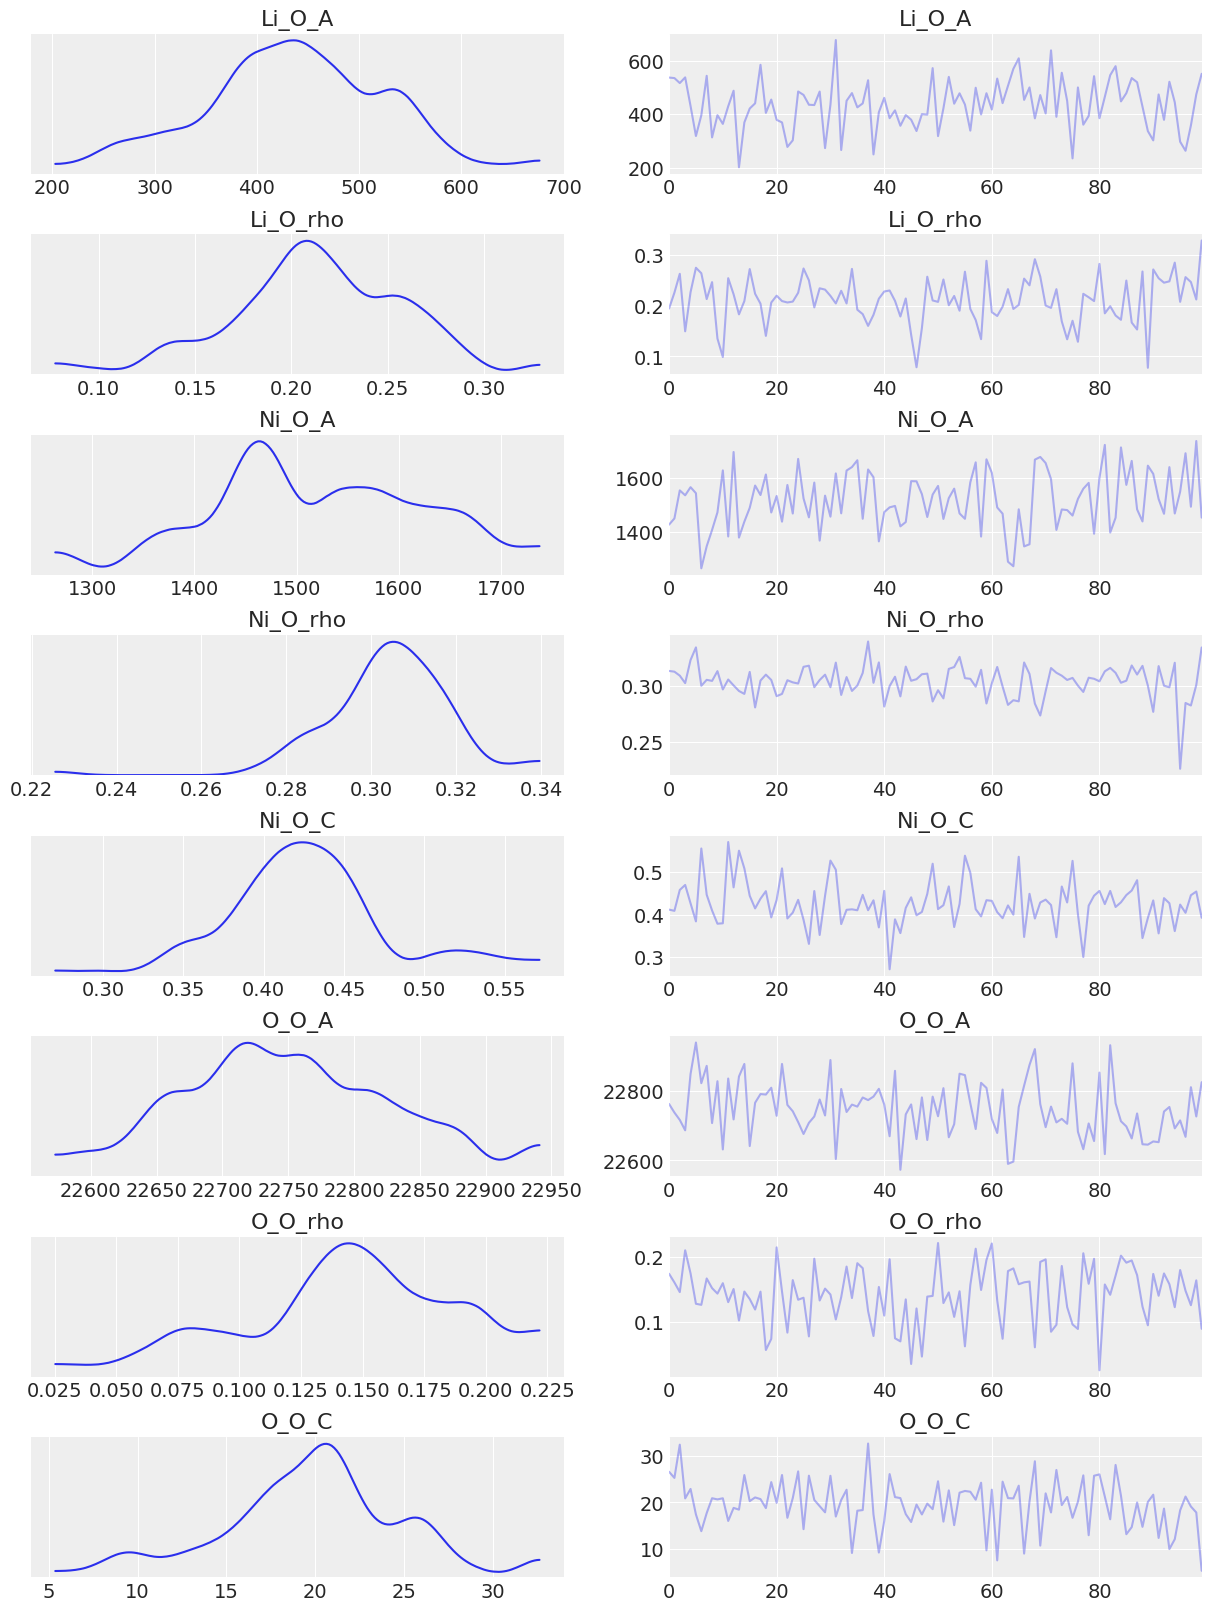

In [9]:
az.style.use('arviz-darkgrid')
az.plot_trace(trace)

/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12de73ac8>,
      dtype=object)

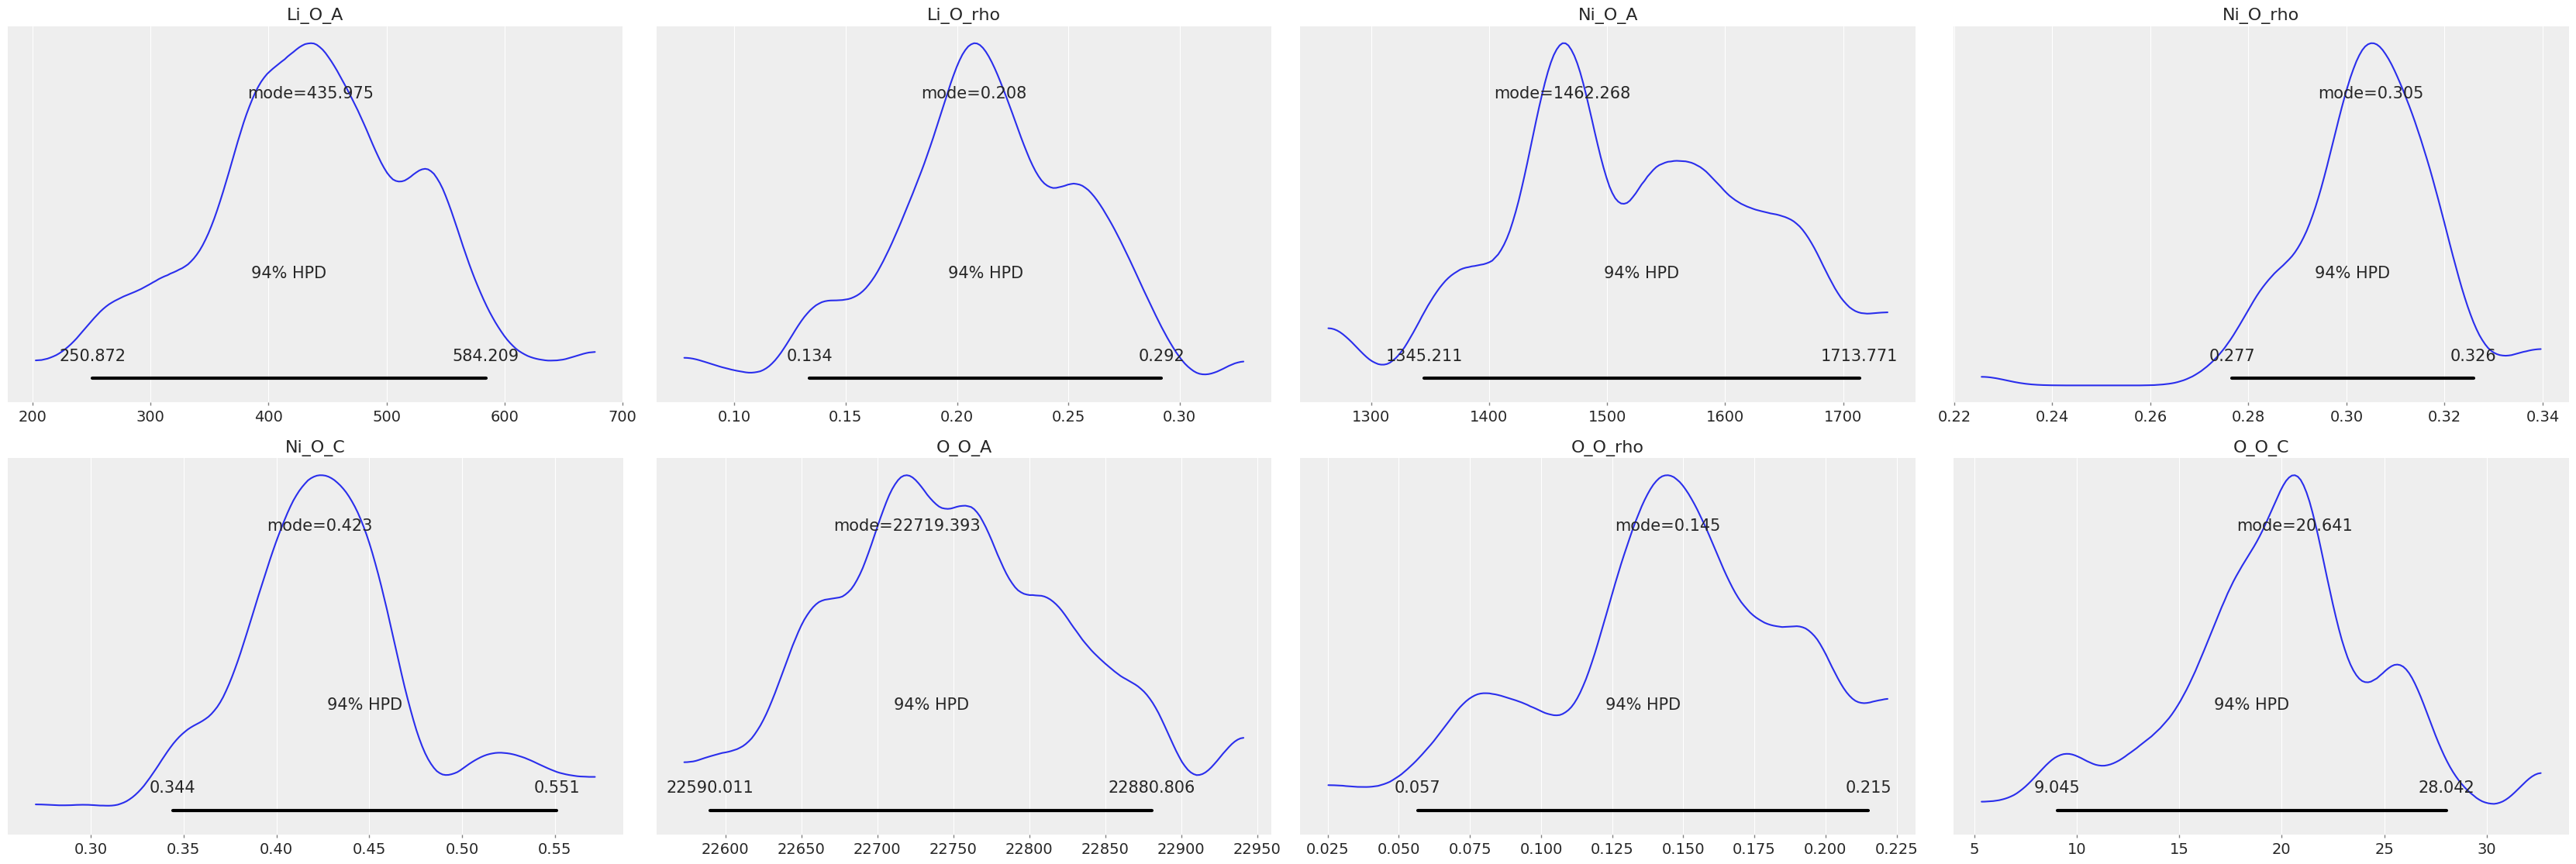

In [10]:
az.plot_posterior(trace, round_to = 3, point_estimate = 'mode')